# ⏱ High-level `TimedModule` API

## Constructing a `TimedModule`

In [1]:
# - Switch off warnings
import warnings
warnings.filterwarnings('ignore')

# - Useful imports
import numpy as np

try:
    from rich import print
except:
    pass

from rockpool.nn.combinators import Sequential
from rockpool.nn.modules import Rate, Linear

# - Construct the TimedModule
Nin = 1
Nout = 5
dt = 1e-3
tmod = Sequential(Linear((Nin, Nout)), Rate(Nout)).timed(dt = dt)
print(tmod)

TimedModuleWrapper  with shape (1, 5) {
    ModSequential '_module' with shape (1, 5) {
        Linear '0_Linear' with shape (1, 5)
        Rate '1_Rate' with shape (5,)
    }
} with ModSequential '_module' as module

## Evolving a `TimedModule`

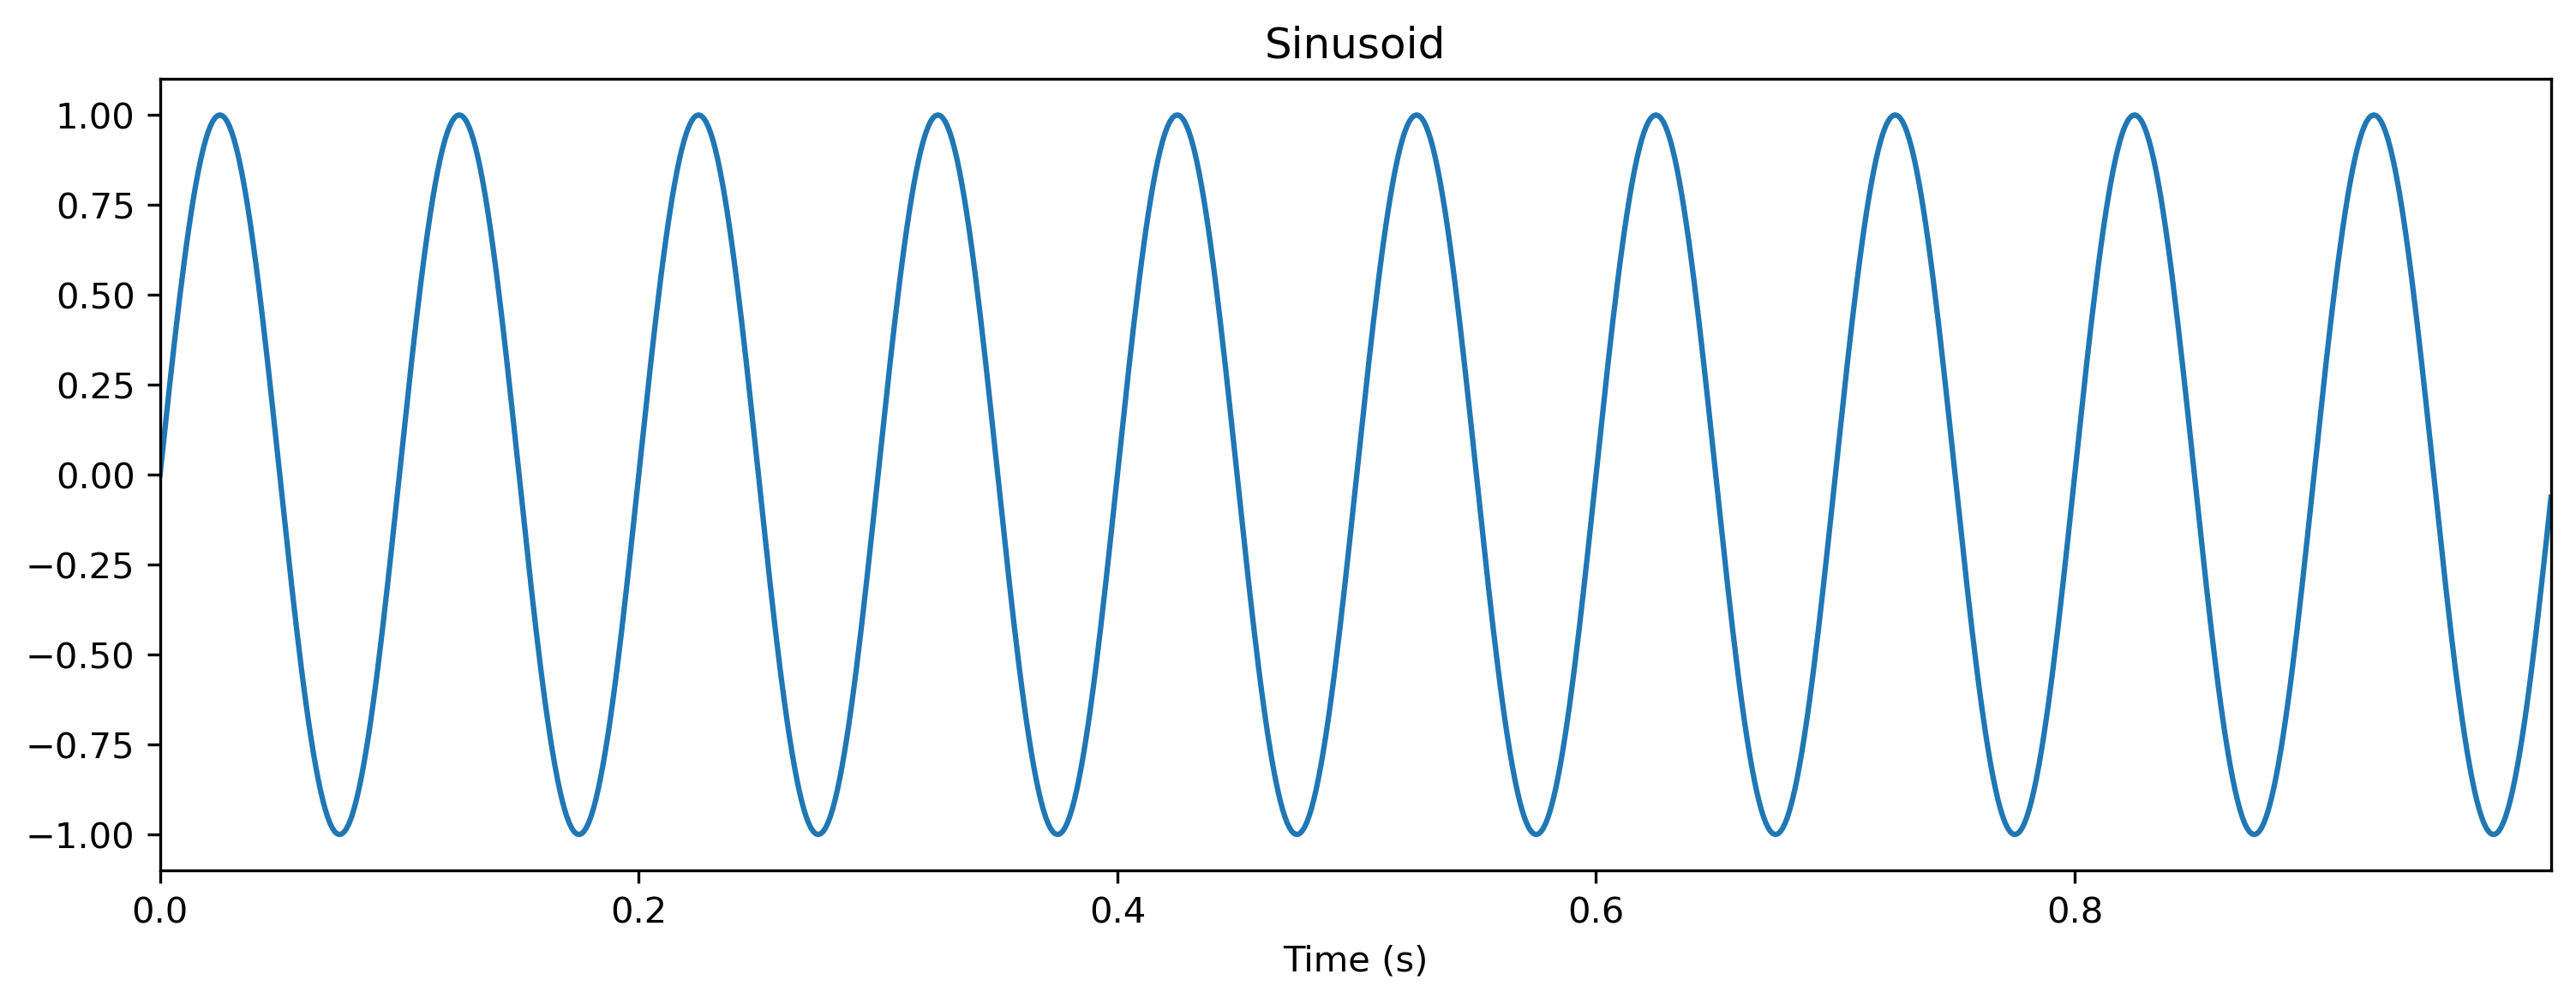

In [2]:
# - Import time-series handling classes
from rockpool import TSContinuous

# - Import and configure matplotlib for plotting
import sys
!{sys.executable} -m pip install --quiet matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 300

# - Create a sinusoidal input signal
T = 1000
omega = 10
time_base = np.arange(T) * dt
ts_sin = TSContinuous.from_clocked(
    np.sin(time_base * 2 * np.pi * omega),
    dt = dt,
    periodic = True,
    name = 'Sinusoid',
)
ts_sin.plot();

non-periodic TSContinuous object `Output samples` from t=0.0 to 1.0. Samples: 1000. Channels: 5

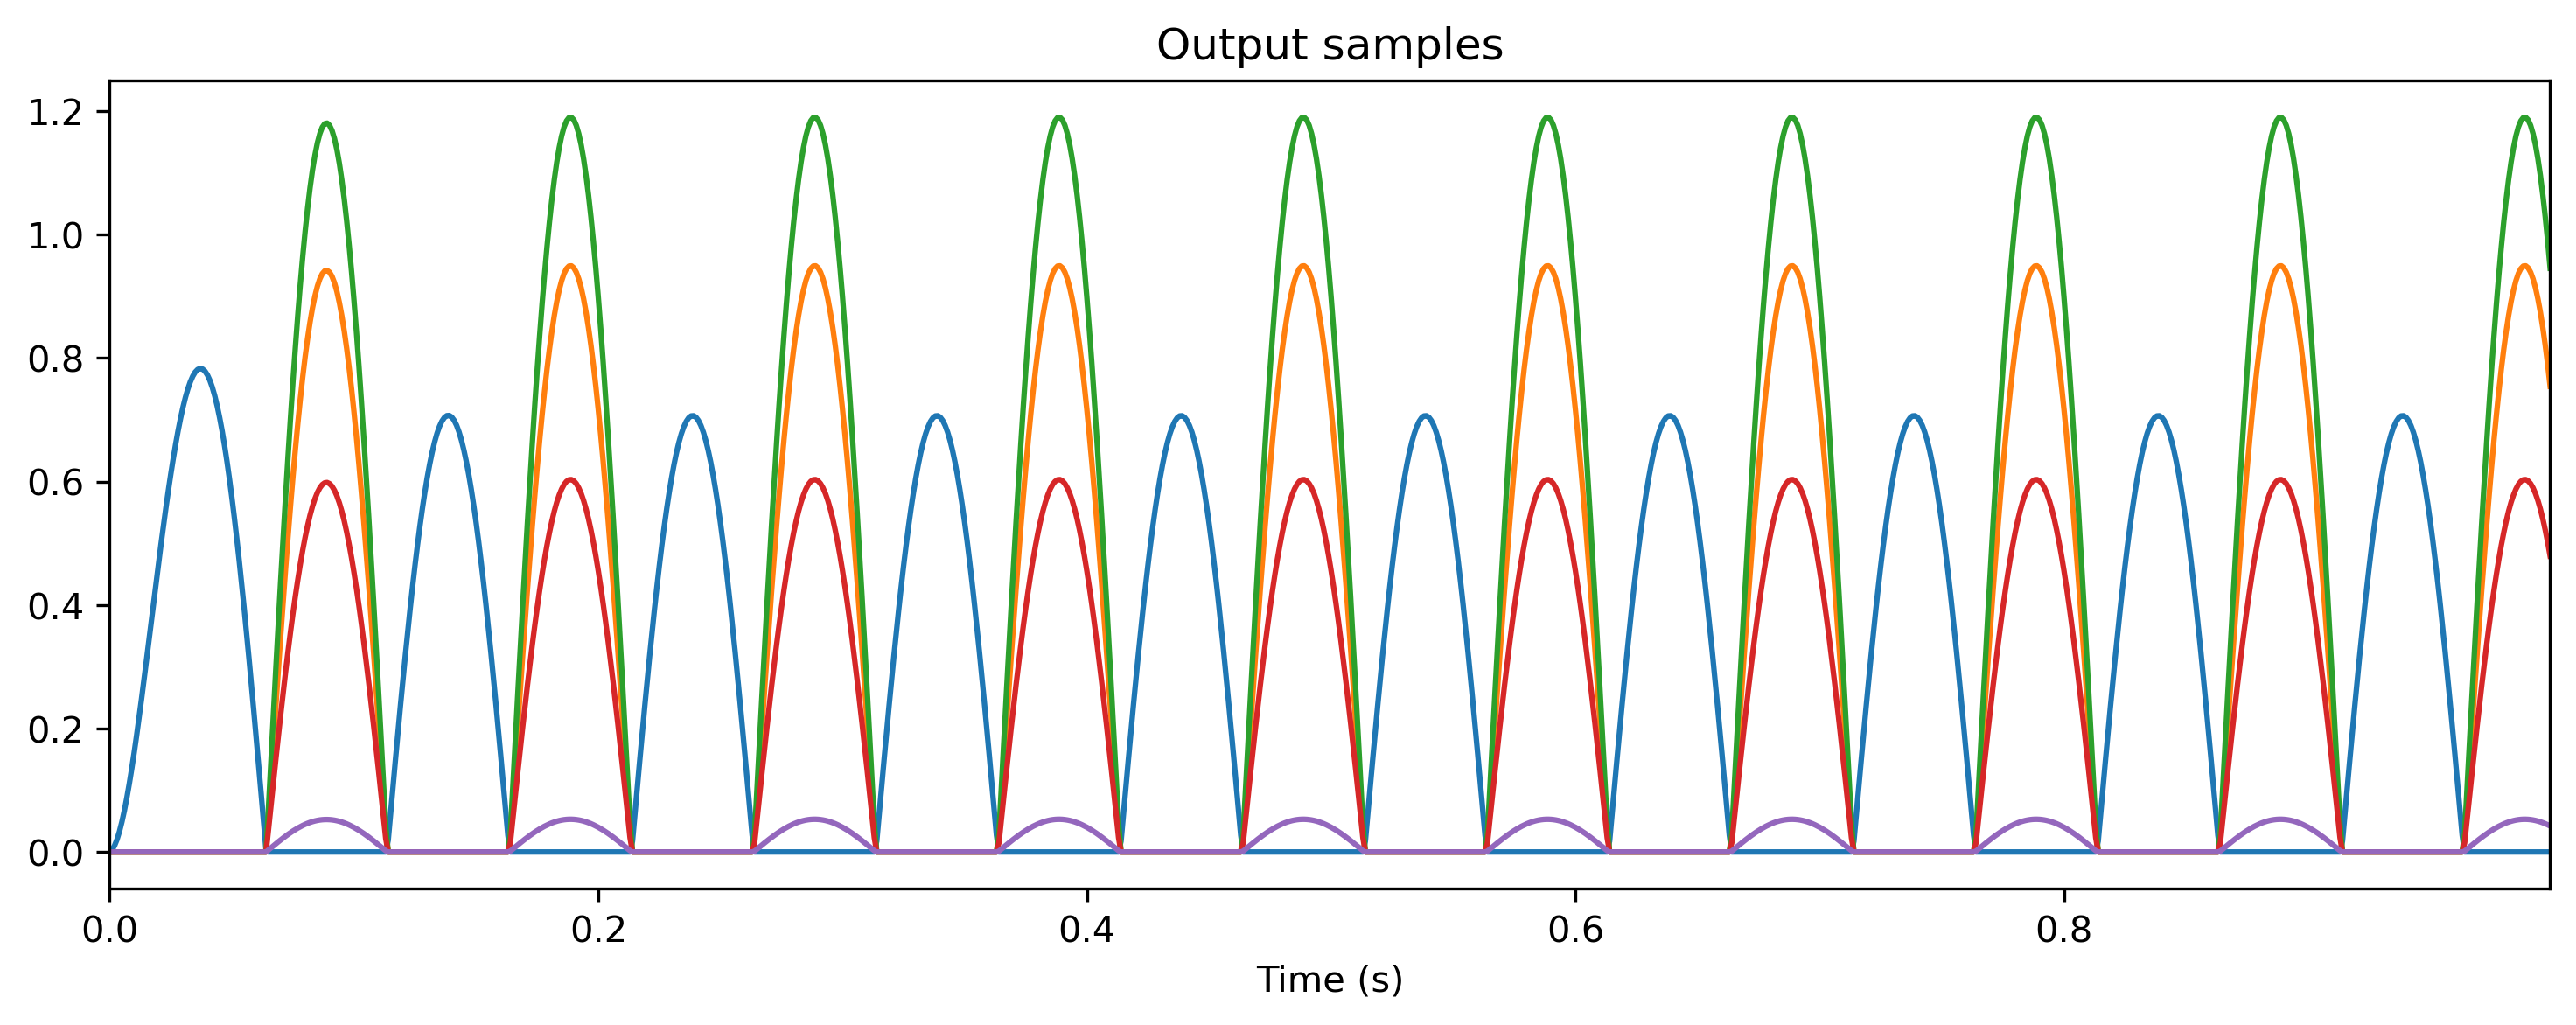

In [3]:
# - Evolve the TimedModule
output_ts, _, _ = tmod(ts_sin)
plt.figure();
print(output_ts);
output_ts.plot();

## Inspecting a `TimedModule`

In [4]:
# - Examine the parameters
print('Parameters:', tmod.parameters())

# - Examine the state
print('State:', tmod.state())

# - Examine the simulation parameters
print('Simulation parameters:', tmod.simulation_parameters())

# - `TimedModules` also have time
print('Time:', tmod.t)

Parameters:
{
    '_module': {
        '0_Linear': {'weight': array([[ 1.1175366 , -1.50156676, -1.88202227, -0.95408104, -0.08374108]])},
        '1_Rate': {
            'tau': array([0.02, 0.02, 0.02, 0.02, 0.02]),
            'bias': array([0., 0., 0., 0., 0.]),
            'threshold': array([0., 0., 0., 0., 0.])
        }
    }
}

State:
{
    '_module': {
        '0_Linear': {},
        '1_Rate': {'x': array([-0.56143606,  0.75436789,  0.94550386,  0.47931808,  0.04207044])}
    }
}

Simulation parameters:
{
    'dt': 0.001,
    '_module': {
        'dt': 0.001,
        '0_Linear': {},
        '1_Rate': {'dt': 0.001, 'noise_std': 0.0, 'act_fn': <function H_ReLU at 0x7f05e46a4ee0>}
    }
}

Time: 1.0

## Building a network using nested `TimedModule` s

In [5]:
# - Import the base class and a TimedModule to use as a submodule
from rockpool.nn.modules import TimedModule, Rate
from rockpool.parameters import Parameter
from rockpool import TimeSeries

# - Define a new TimedModule
class ffwd_tmod_net(TimedModule):
    # - Provide an `__init__` method to specify required parameters and modules
    #   Here you check, define and initialise whatever parameters and
    #   state you need for your module.
    def __init__(self,
                 shape,
                 dt = 1.,
                 *args,
                 **kwargs,
                ):
        # - Call superclass initialisation
        #   This is always required for a `Module` class
        super().__init__(shape = shape, dt = dt, *args, **kwargs)

        # - Specify weights attributes
        #   We need a weights matrix for our input weights.
        #   We specify the shape explicitly, and provide an initialisation function.
        #   We also specify a family for the parameter, "weights". This is used to
        #   query parameters conveniently, and is a good idea to provide.
        self.w_0 = Parameter(
            shape = self.shape[0:2],
            init_func = lambda s: np.zeros(s),
            family = 'weights',
        )

        self.w_1 = Parameter(
            shape = self.shape[1:3],
            init_func = lambda s: np.zeros(s),
            family = 'weights',
        )
    
        self.w_2 = Parameter(
            shape = self.shape[2:4],
            init_func = lambda s: np.zeros(s),
            family = 'weights',
        )

        # - Specify and add submodules
        #   These will be the neurons in our layer, to receive the weighted
        #   input signals. This sub-module will be automatically configured
        #   internally, to specify the required state and parameters
        self.neurons1 = Rate(self.shape[1], dt = dt).timed()
        self.neurons2 = Rate(self.shape[2], dt = dt).timed()
        
    # - The `evolve` method contains the internal logic of your module
    #   `evolve` takes care of passing data in and out of the module,
    #   and between sub-modules if present.
    def evolve(self,
               ts_input: TimeSeries,
               duration: float,
               num_timesteps: int,
               record: bool = False,
               *args, **kwargs):
        # - Pass input data through the input weights
        x = ts_input @ self.w_0

        # - Pass the signals through the neurons and hidden weights
        x, _, _ = self.neurons1(x)
        x = x @ self.w_1
        x, _, _ = self.neurons2(x)
        x = x @ self.w_2
        
        # - Return the module output
        return x, {}, {}

In [6]:
Nin = 3
Nout = 1
dt = 1

tmod = ffwd_tmod_net((Nin, 5, 7, Nout), dt = dt)
print(tmod)

ffwd_tmod_net  with shape (3, 5, 7, 1) {
    TimedModuleWrapper 'neurons1' with shape (5, 5) {
        Rate '_module' with shape (5,)
    }
    TimedModuleWrapper 'neurons2' with shape (7, 7) {
        Rate '_module' with shape (7,)
    }
}

In [7]:
# - Examine the nested parameters of the TimedModule
print(tmod.parameters())

{
    'w_0': array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]]),
    'w_1': array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]]),
    'w_2': array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]]),
    'neurons1': {
        '_module': {
            'tau': array([0.02, 0.02, 0.02, 0.02, 0.02]),
            'bias': array([0., 0., 0., 0., 0.]),
            'threshold': array([0., 0., 0., 0., 0.])
        }
    },
    'neurons2': {
        '_module': {
            'tau': array([0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]),
            'bias': array([0., 0., 0., 0., 0., 0., 0.]),
            'threshold': array([0., 0., 0., 0., 0., 0., 0.])
        }
    }
}

In [8]:
# - Set the weights to something non-zero
p = tmod.parameters()
p['w_0'] = np.random.normal(size = p['w_0'].shape) + 1
p['w_1'] = np.random.normal(size = p['w_1'].shape) + 1
p['w_2'] = np.random.normal(size = p['w_2'].shape) + 1

# - Assign the new parameters
tmod.set_attributes(p)
print('Weights:', tmod.parameters())

Weights:
{
    'w_0': array([[ 1.73722151,  1.30356212,  0.55156482,  2.8019148 ,  1.09027286],
       [ 1.97210989,  1.88721147,  1.29312512, -0.28583698,  1.45047169],
       [ 0.04967296, -0.94915265,  1.37862991,  1.29235999,  0.050853  ]]),
    'w_1': array([[ 1.52490803,  0.53006083,  3.11873417, -0.15332358,  1.51820289,
         2.88070423, -0.55447475],
       [ 0.03845312,  0.76734798,  0.77595556,  2.23176957, -0.90711186,
         1.39216172,  0.132243  ],
       [ 0.47959018,  0.99225231,  0.54699617,  0.91157126,  0.61972611,
         3.7774115 ,  2.23284232],
       [ 0.56585036,  2.65117266,  0.4449058 ,  0.0736041 ,  0.02211706,
        -0.34763718, -0.79899013],
       [ 1.51294292,  0.81017138,  1.07416865, -1.13288234,  0.92521921,
         1.6997927 ,  1.38329005]]),
    'w_2': array([[-0.01196603],
       [ 1.74152837],
       [-0.35683857],
       [-0.29947419],
       [ 0.38918974],
       [ 1.76011316],
       [ 0.96554928]]),
    'neurons1': {
        '_module': {
            'tau': array([0.02, 0.02, 0.02, 0.02, 0.02]),
            'bias': array([0., 0., 0., 0., 0.]),
            'threshold': array([0., 0., 0., 0., 0.])
        }
    },
    'neurons2': {
        '_module': {
            'tau': array([0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]),
            'bias': array([0., 0., 0., 0., 0., 0., 0.]),
            'threshold': array([0., 0., 0., 0., 0., 0., 0.])
        }
    }
}

Input: periodic TSContinuous object `White noise` from t=0.0 to 1000.0. Samples: 1000. Channels: 3

Output: non-periodic TSContinuous object `Output samples ''neurons2''` from t=0.0 to 1000.0. Samples: 1000. 
Channels: 1

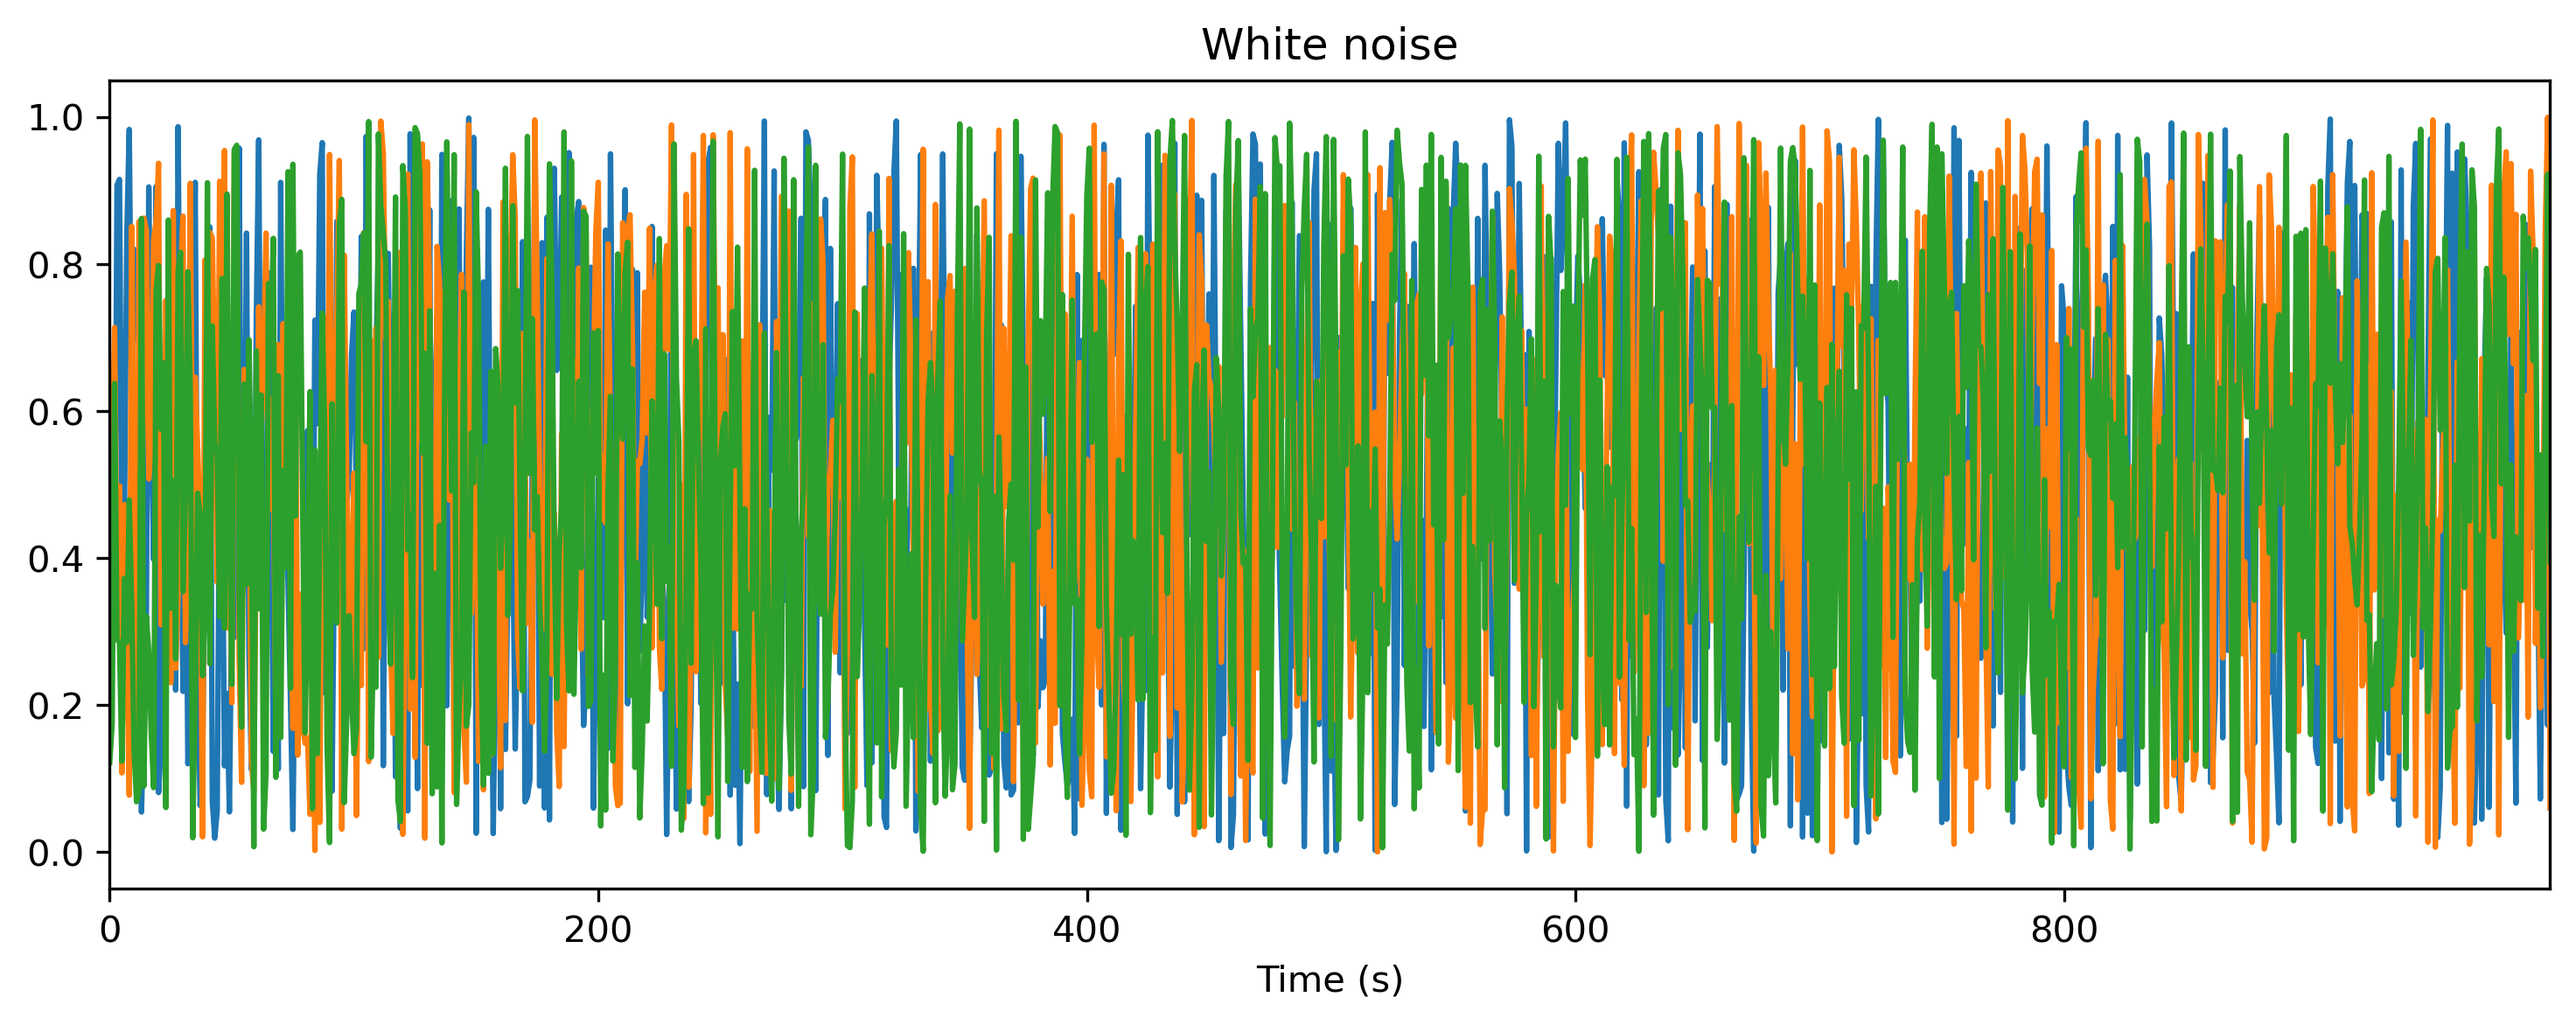

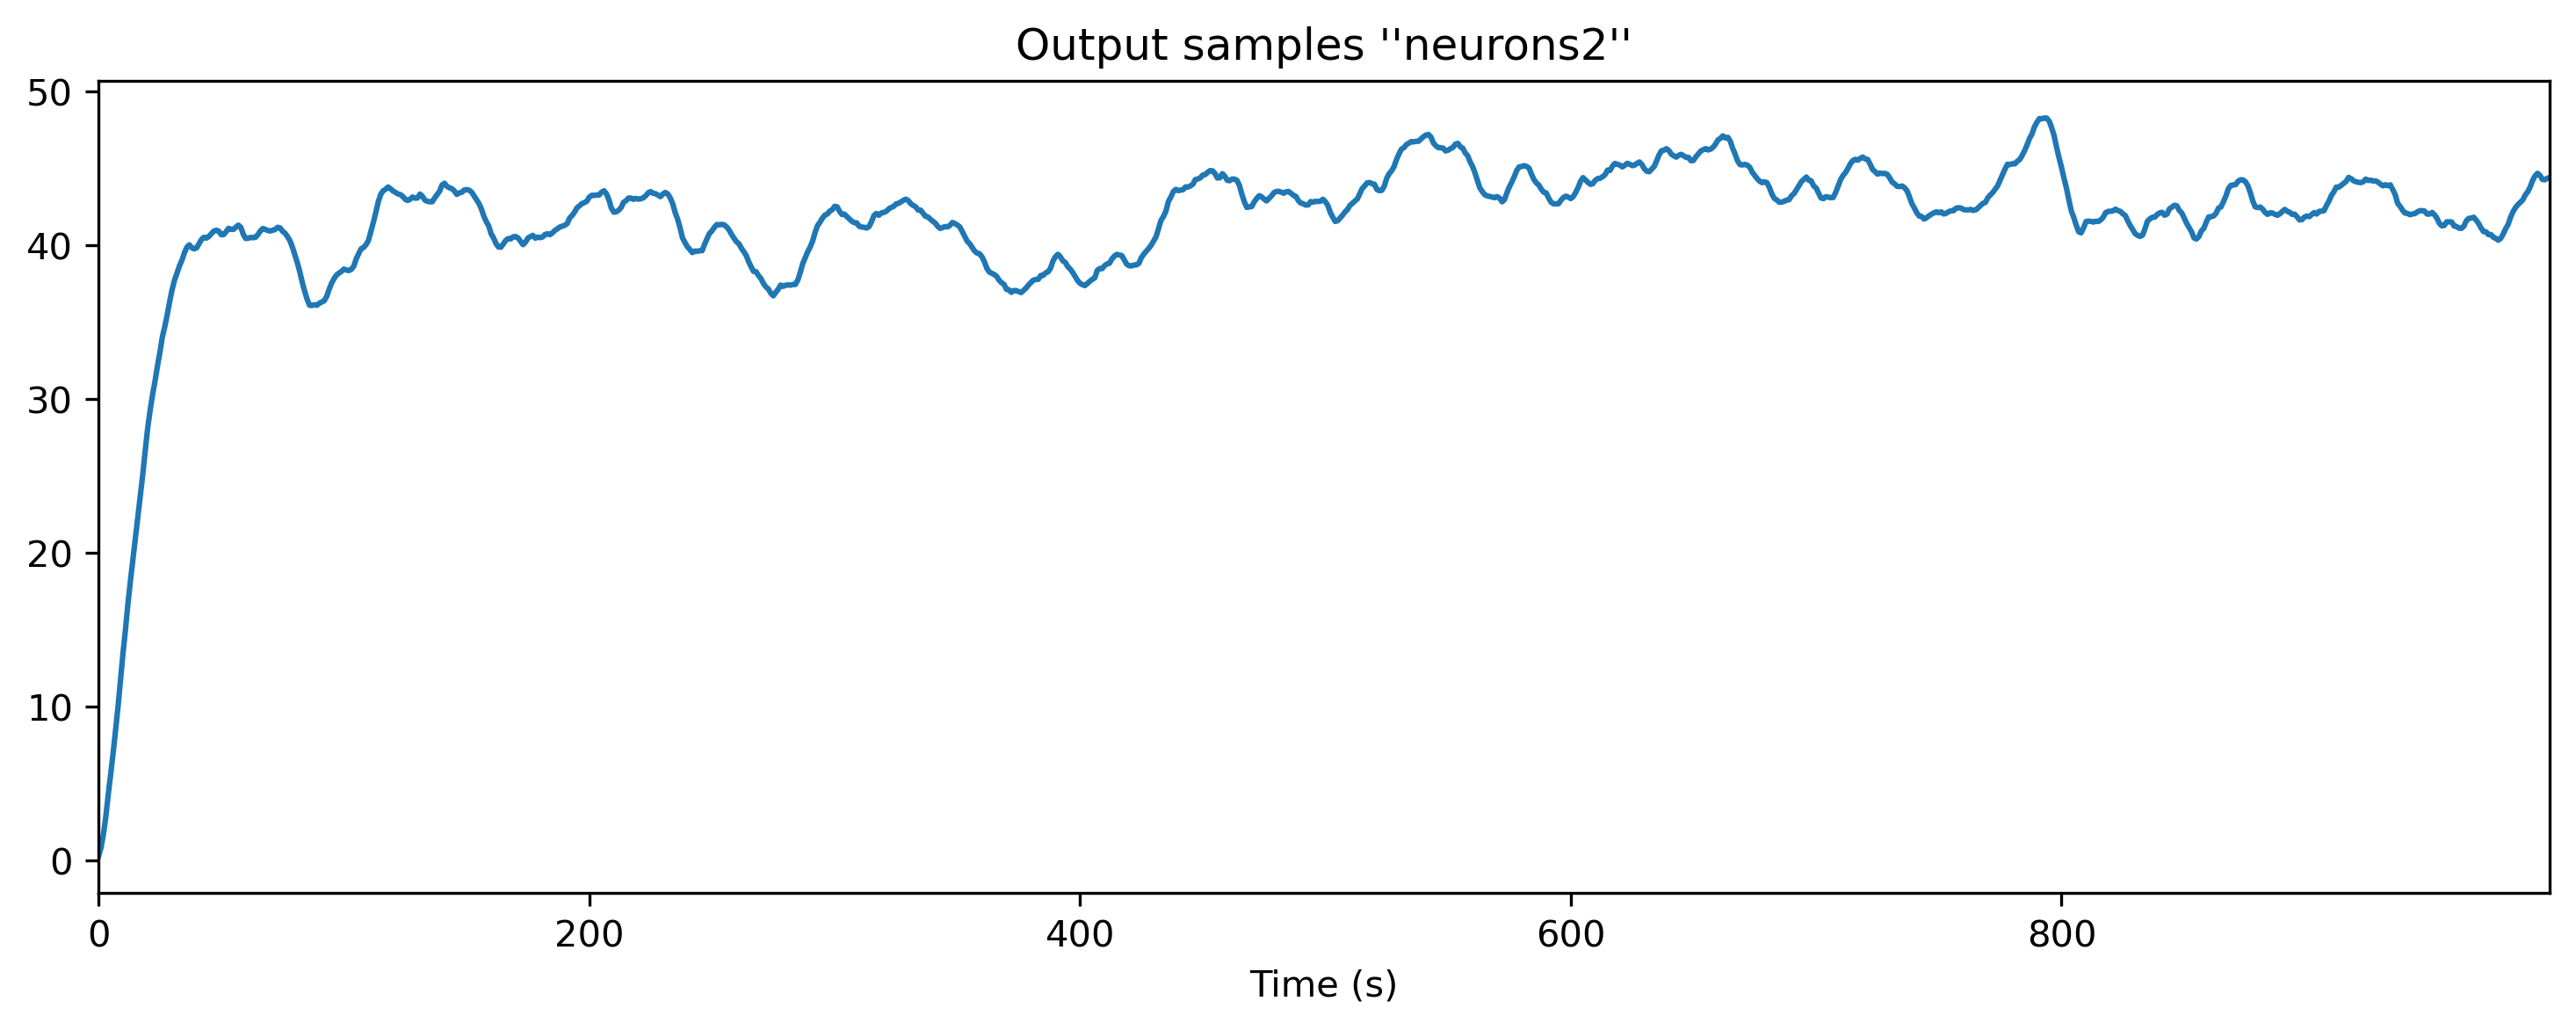

In [9]:
# - Generate some white noise input
ts_input = TSContinuous.from_clocked(np.random.rand(1000, Nin),
                                     name = 'White noise',
                                     dt = dt, periodic = True,
                                    )
print('Input:', ts_input)
ts_input.plot()

# - Evolve the TimedModule with the input
ts_output, _, rec = tmod(ts_input)

# - Display the output
print('Output:', ts_output)
plt.figure()
ts_output.plot();

## Building a network using internal `Module` s

In [10]:
# - Import the base class and a Module to use as a submodule
from rockpool.nn.modules import TimedModule
from rockpool.parameters import Parameter
from rockpool.nn.modules import RateJax
from rockpool import TimeSeries

# - Define a new TimedModule
class ffwd_tmod_net2(TimedModule):
    # - Provide an `__init__` method to specify required parameters and modules
    #   Here you check, define and initialise whatever parameters and
    #   state you need for your module.
    def __init__(self,
                 shape,
                 *args,
                 **kwargs,
                ):
        # - Call superclass initialisation
        #   This is always required for a `Module` class
        super().__init__(shape = shape, *args, **kwargs)

        # - Specify weights attributes
        #   We need weights matrices for our layer weights.
        #   We specify the shapes explicitly, and provide an initialisation function.
        #   We also specify a family for the parameter, "weights". This is used to
        #   query parameters conveniently, and is a good idea to provide.
        self.w0 = Parameter(shape = self.shape[0:2],
                            init_func = lambda s: np.zeros(s),
                            family = 'weights',
                            )

        self.w1 = Parameter(shape = self.shape[1:3],
                            init_func = lambda s: np.zeros(s),
                            family = 'weights',
                            )
        
        # - Specify and add submodules
        #   These will be the neurons in our layer, to receive the weighted
        #   input signals. These sub-modules will be automatically configured
        #   internally, to specify the required state and parameters
        self.neurons0 = RateJax(self.shape[1])
        self.neurons1 = RateJax(self.shape[2])
        
    # - The `evolve` method contains the internal logic of your module
    #   `evolve` takes care of passing data in and out of the module,
    #   and between sub-modules if present.
    def evolve(self,
               ts_input: TimeSeries,
               duration: float,
               num_timesteps: int,
               record: bool = False,
               *args, **kwargs):
        # - First we need to rasterise the input time series.
        #   We can use the convenience method `_prepare_input()` for this
        time_base, input_raster, num_timesteps = self._prepare_input(
            ts_input, duration, num_timesteps
        )
        
        # - Pass input data through the input weights
        x0 = input_raster @ self.w0
        
        # - Pass the signals through the neurons
        x1, _, _ = self.neurons0(x0)
        
        # - Second layer weights
        x2 = x1 @ self.w1
        
        # - Second layer neurons
        x3, _, _ = self.neurons1(x2)
        
        # - We need to re-wrap the output raster as a TimeSeries object
        #   To do this we can use the convenience method `_gen_timeseries()`
        output_ts = self._gen_timeseries(x3)
        
        # - Return the module output
        return output_ts, {}, {}

In [11]:
# - Instantiate the module
tmod = ffwd_tmod_net2((Nin, 5, 7, Nout), dt = dt)
print(tmod)

ffwd_tmod_net2  with shape (3, 5, 7, 1) {
    RateJax 'neurons0' with shape (5,)
    RateJax 'neurons1' with shape (7,)
}

Input: periodic TSContinuous object `White noise` from t=0.0 to 1000.0. Samples: 1000. Channels: 3

Output: non-periodic TSContinuous object `Output samples` from t=0.0 to 1000.0. Samples: 1000. Channels: 7

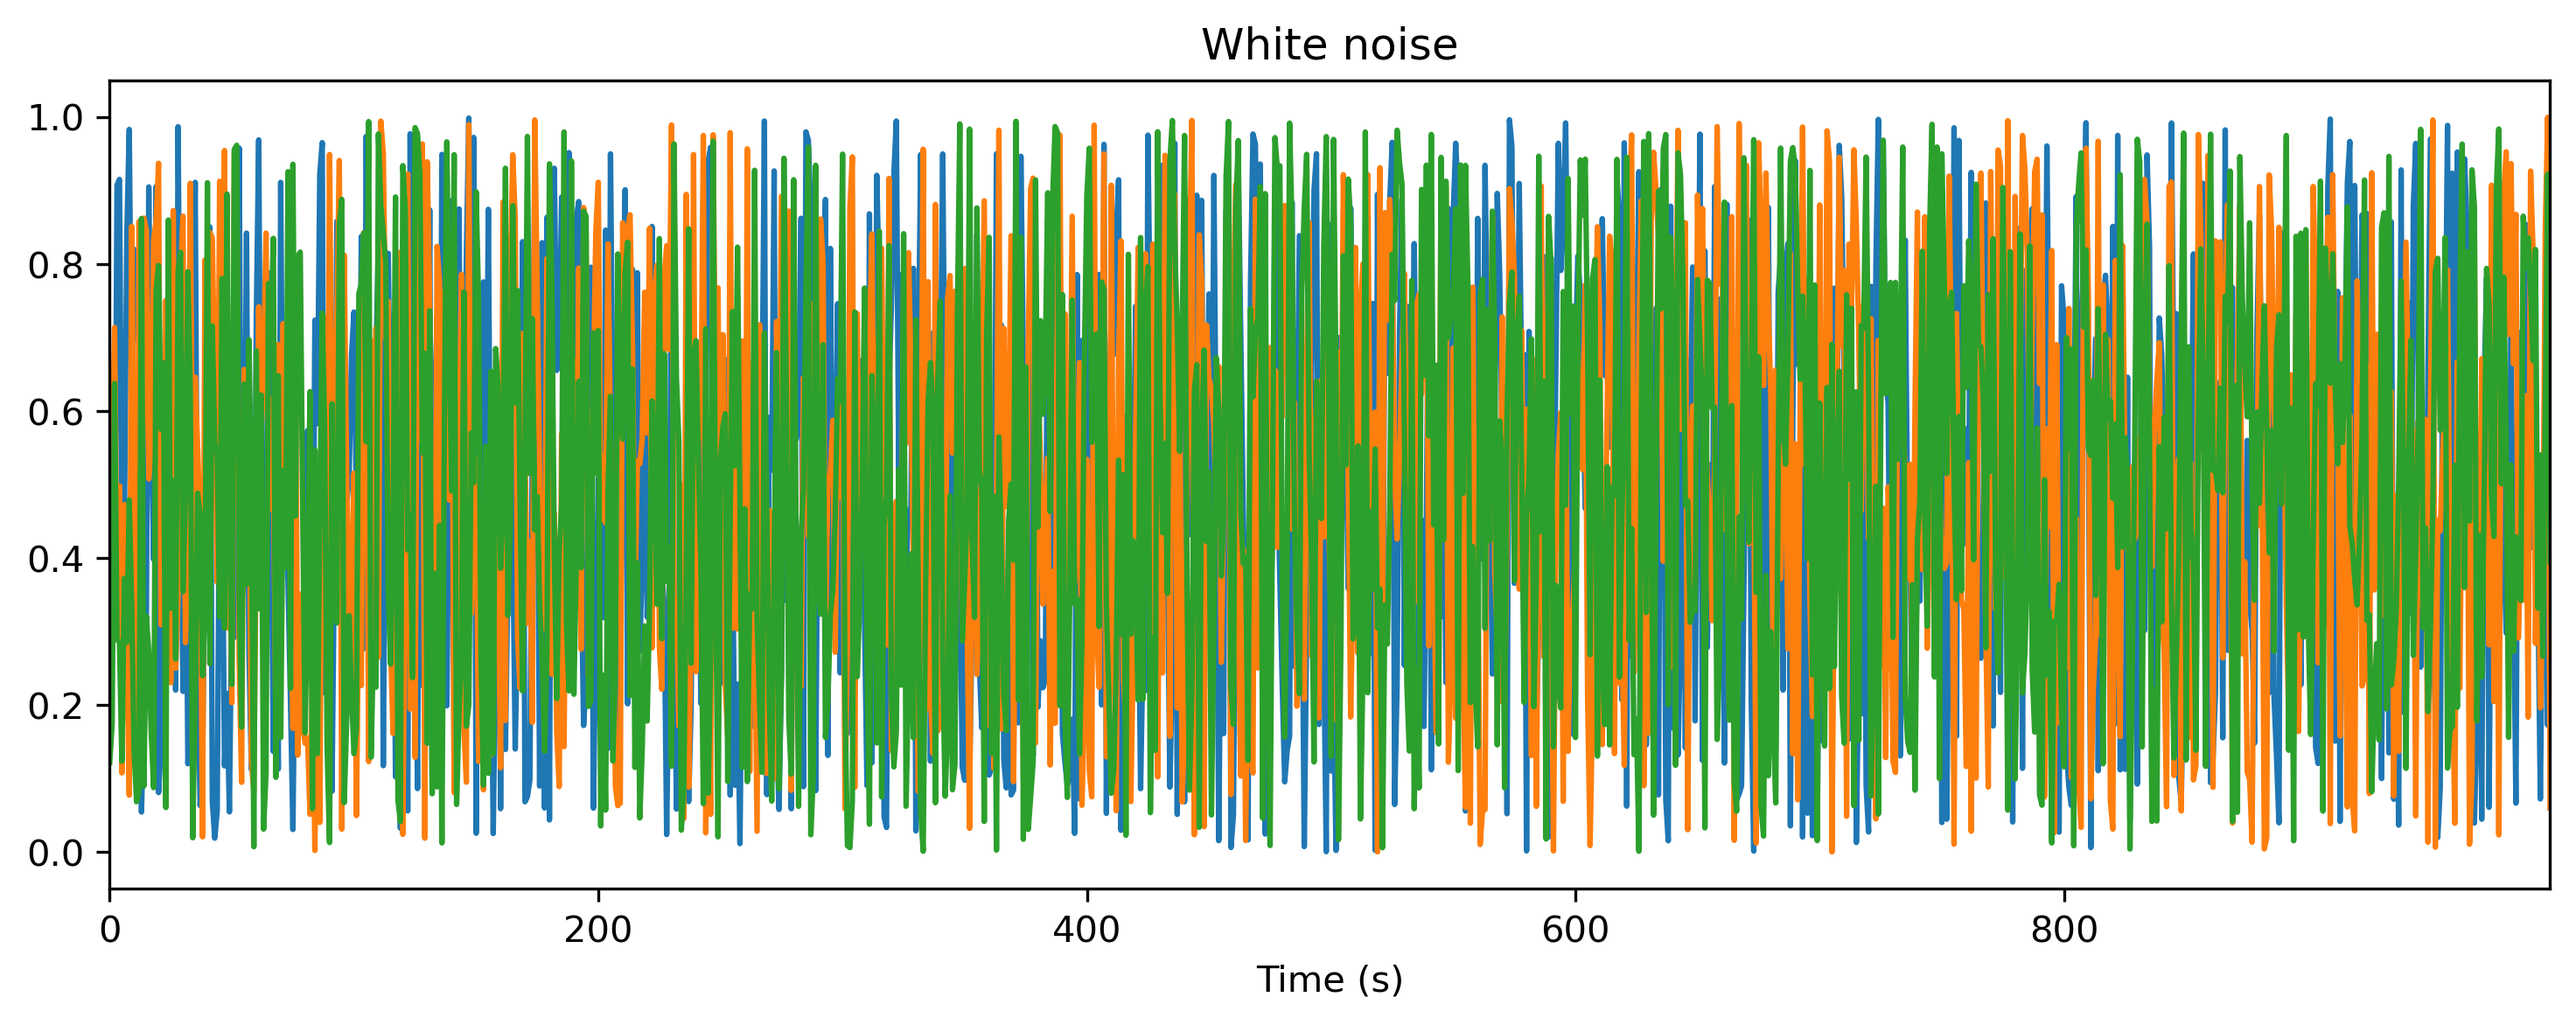

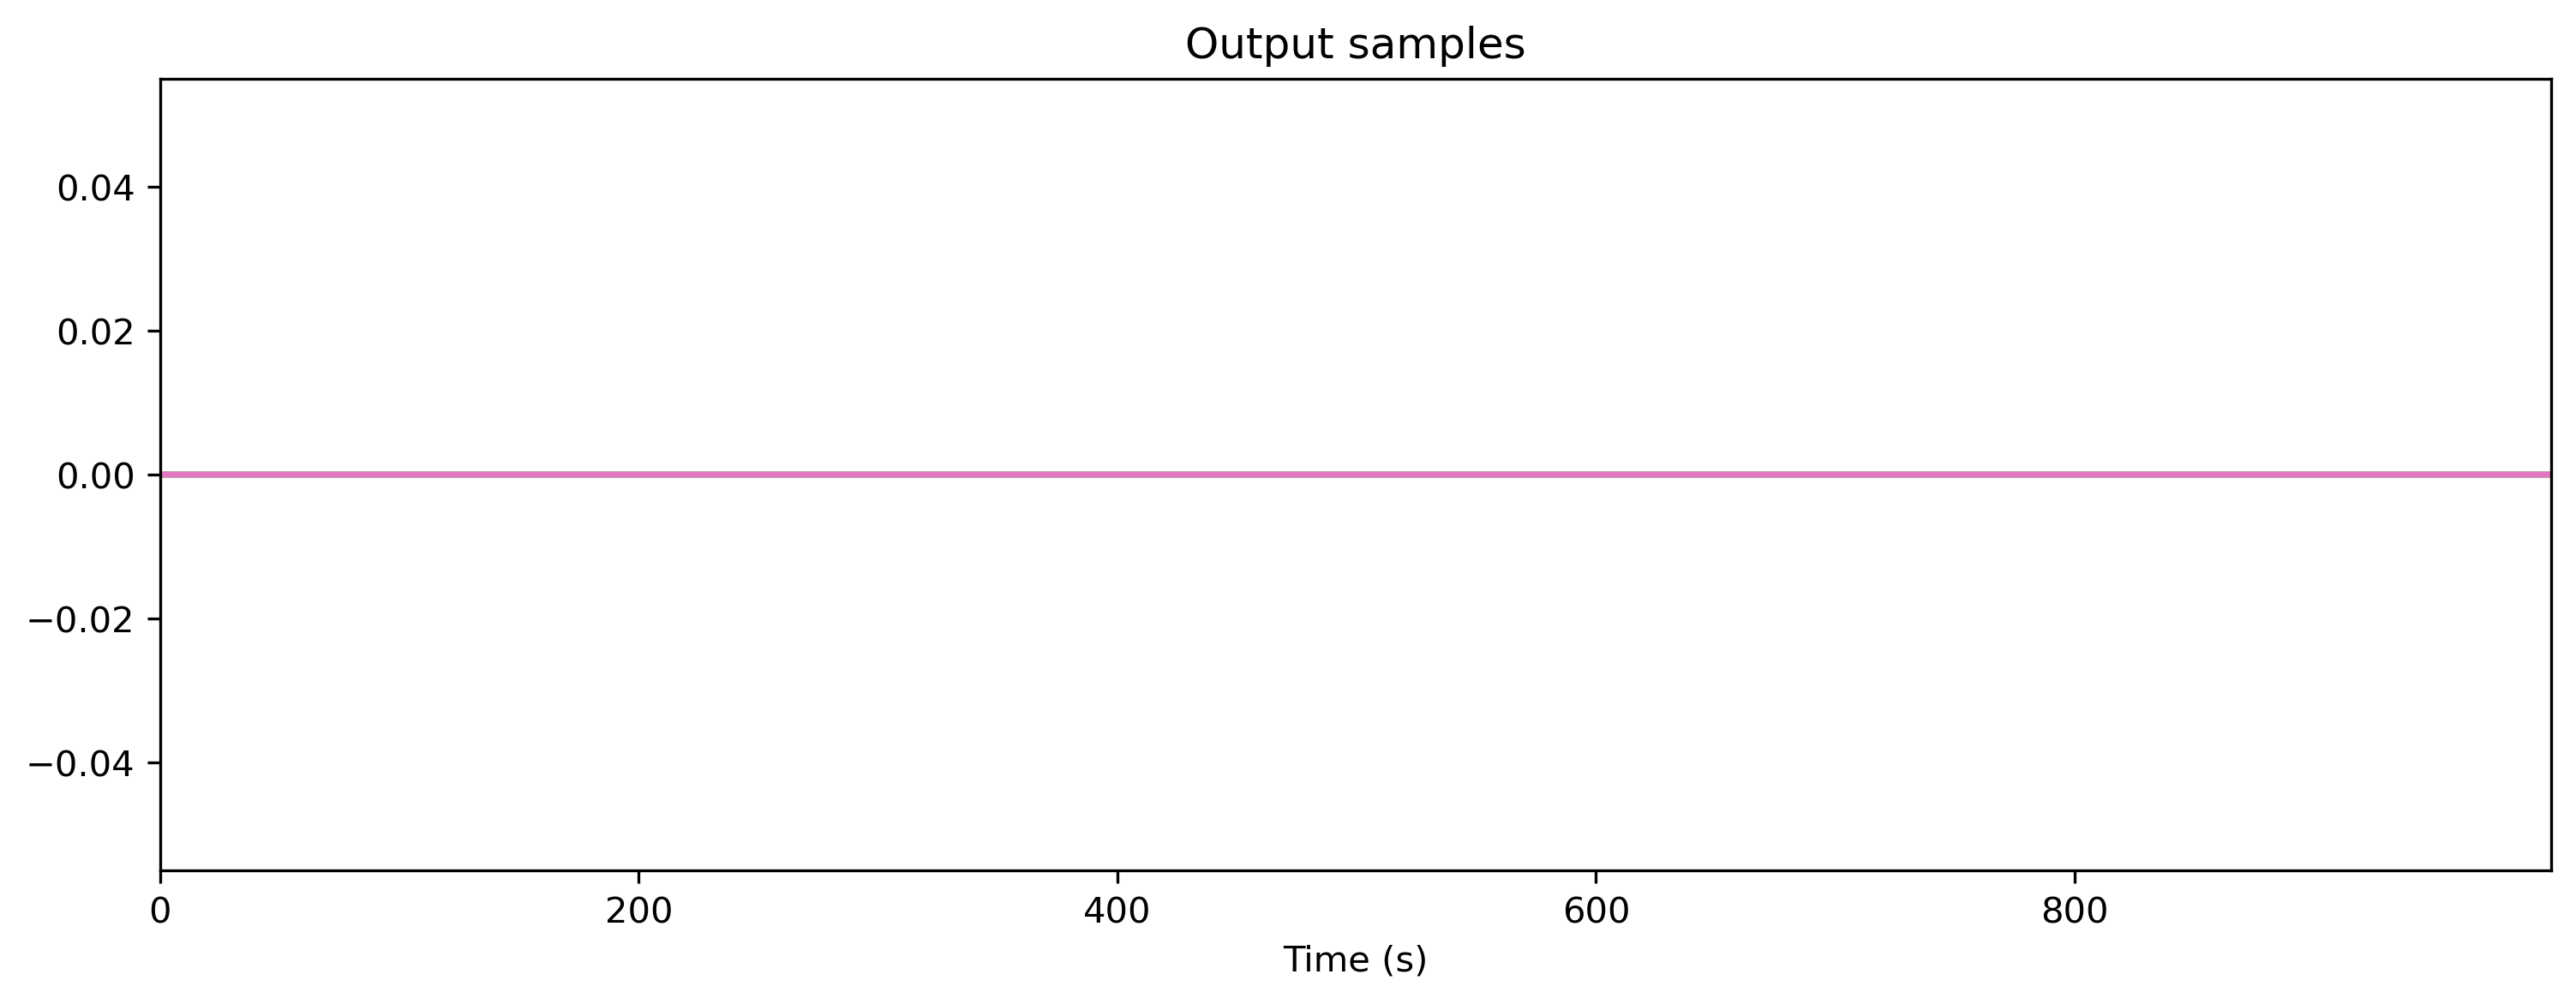

In [12]:
print('Input:', ts_input)
ts_input.plot()

# - Evolve the TimedModule with the input
ts_output, _, rec = tmod(ts_input)

# - Display the output
print('Output:', ts_output)
plt.figure()
ts_output.plot();

## Converting a low-level API `Module` to a high-level API `TimedModule`

In [13]:
# - Import the converter class
from rockpool.nn.modules.timed_module import TimedModuleWrapper
from rockpool.nn.modules import RateJax

# - Generate a module and wrap as a TimedModule
mod = RateJax(4)
tmod = TimedModuleWrapper(mod)
print(tmod)

TimedModuleWrapper  with shape (4, 4) {
    RateJax '_module' with shape (4,)
} with RateJax '_module' as module

In [14]:
# - Use the conversion method
from rockpool.nn.modules import RateJax

# - Generate a module and wrap as a TimedModule
tmod = RateJax(4).timed()
print(tmod)

TimedModuleWrapper  with shape (4, 4) {
    RateJax '_module' with shape (4,)
} with RateJax '_module' as module

## `TimedModule` API reference

### High-level attributes and methods provided by `TimedModule`

### Low-level attributes and methods inherited from `Module`